In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

In [2]:
k = 2
m = 30
n = 5000

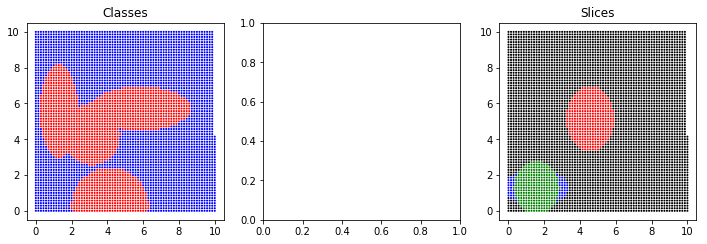

In [3]:
L, X, Y, Z = generate_dataset(k, m, n, Z_kwargs={'num_slices': 3})

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.552,0.538,0.456,180,96,0.652174
1,"[1, 2]",0.138,0.136,0.106,40,29,0.579710
2,"[1, 2]",0.324,0.314,0.248,146,16,0.901235
3,"[1, 2]",0.020,0.018,0.012,9,1,0.900000
4,"[1, 2]",0.080,0.080,0.070,24,16,0.600000
5,"[1, 2]",0.104,0.088,0.074,33,19,0.634615
6,"[1, 2]",0.120,0.120,0.094,32,28,0.533333
7,"[1, 2]",0.142,0.142,0.110,59,12,0.830986
8,"[1, 2]",0.036,0.036,0.030,12,6,0.666667
9,"[1, 2]",0.228,0.226,0.166,73,41,0.640351


In [7]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [ ]:
# np.save('synthetic_data.npy', (L, Y))

# Learn

In [ ]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [8]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Inferred cardinality: 2


In [9]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.808

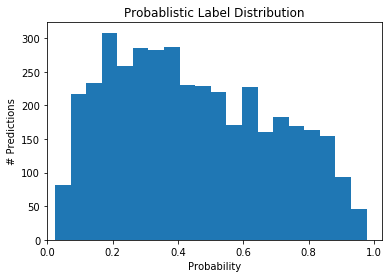

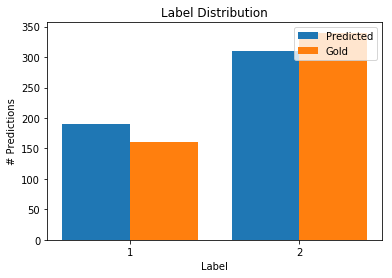

In [10]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [ ]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset
# from metal.contrib.slicing.utils import evaluate_slicing

# eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

# results = {}
# for model_name, model in trained_models.items():
#     scores = evaluate_slicing(model, eval_loader, verbose=False)
#     results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
# import pandas as pd
# pd.DataFrame.from_dict(results)

### EndModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [ ]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))

### SliceModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

In [ ]:
import torch.nn as nn
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

n, m = Ls[0].shape
input_dim = Xs[0].shape[1]

input_module = MLPModule(input_dim, 10, [10], bias=True)
slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
                           verbose=False)
slice_model.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

### New SliceModel

In [ ]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

In [ ]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

In [ ]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [ ]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

### Repeated Trials

In [ ]:
# Grid search as necessary first


In [ ]:
from metal.utils import split_data, SlicingDataset
from metal.label_model.baselines import MajorityLabelVoter
from metal.end_model import EndModel
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.synthetics.geometric_synthetics import *
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.slicing.utils import evaluate_slicing

import torch
from torch.utils.data import DataLoader

NUM_TRIALS = 3
SPLIT = 2

k = 2
m = 30
n = 5000

batchsize = 32
layer_output_dims = [2, 10, 10, 2]
slice_weight = 0.1

summary = {}
for model in ['mv', 'dp', 'up', 'me', 'sm']:
    summary[model] = {
        'overall': [],
        'slices': []
    }

for i in range(NUM_TRIALS):
    L, X, Y, Z = generate_dataset(k, m, n, plotting=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
    lm = SnorkelLabelModel()
    lm.train_model(Ls[0])
    Y_train_ps = lm.predict_proba(Ls[0])

    dev_loader = DataLoader(
        SlicingDataset(Xs[1], Ys[1]),
        batch_size=256,
    )
    eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))
    
    # Train dp
    em_train_loader = DataLoader(
        SlicingDataset(Xs[0], Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )    
    
    dp = EndModel(layer_output_dims)
    dp.train_model(
        em_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )

    dp_results = evaluate_slicing(dp, eval_loader, verbose=False)
    summary['dp']['overall'].append(dp_results['all']['accuracy'])
    for s in range(1,5):
        summary['dp']['slices'].append(dp_results[f'slice_{s}']['accuracy'])    
    
    # Train dp_sm
    L_train = torch.Tensor(np.asarray(Ls[0].todense()))    
    sm_train_loader = DataLoader(
        SlicingDataset(Xs[0], L_train, Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )
    
    dp = EndModel(layer_output_dims) # Fresh copy to be safe
    sm = SliceHatModel(dp, m, slice_weight=slice_weight)
    sm.train_model(
        sm_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )
    
    sm_results = evaluate_slicing(sm, eval_loader, verbose=False)
    summary['sm']['overall'].append(sm_results['all']['accuracy'])
    for s in range(1,5):
        summary['sm']['slices'].append(sm_results[f'slice_{s}']['accuracy'])

print(summary['dp'])
print(summary['sm'])

In [10]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

dp_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    }
}

uni_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    }
}

up_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5
}

moe_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "expert_train_kwargs": {"n_epochs": 10},
    "gating_dim": 5
}

sm_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "slice_kwargs": {
        "slice_weight": 0.1,
    }
}


---------- Training DP ----------

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Inferred cardinality: 2
Saving model at iteration 0 with best score 0.816
[E:0]	Train Loss: 0.693	Dev accuracy: 0.816
[E:1]	Train Loss: 0.692	Dev accuracy: 0.804
[E:2]	Train Loss: 0.692	Dev accuracy: 0.698
[E:3]	Train Loss: 0.692	Dev accuracy: 0.686
Saving model at iteration 4 with best score 0.870
[E:4]	Train Loss: 0.692	Dev accuracy: 0.870
[E:5]	Train Loss: 0.692	Dev accuracy: 0.844
[E:6]	Train Loss: 0.692	Dev accuracy: 0.670
[E:7]	Train Loss: 0.691	Dev accuracy: 0.764
Saving model at iteration 8 with best score 0.890
[E:8]	Train Loss: 0.692	Dev accuracy: 0.890
[E:9]	Train Loss: 0.691	Dev accuracy: 0.844
Restoring best model from iteration 

100%|██████████| 16/16 [00:00<00:00, 1272.57it/s]

Accuracy: 0.890
        y=1    y=2   
 l=1    120    44    
 l=2    11     325   
All: 500 examples


Accuracy: 0.894
Precision: 0.739
Recall: 0.868
F1: 0.798
        y=1    y=2   
 l=1    105    37    
 l=2    16     342   

Slice 0: 405 examples
Accuracy: 0.881
Precision: 0.699
Recall: 0.887
F1: 0.782
        y=1    y=2   
 l=1    86     37    
 l=2    11     271   

Slice 1: 27 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     27    

Slice 2: 40 examples
Accuracy: 0.925
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     3     37    

Slice 3: 7 examples
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
        y=1    y=2   
 l=1     4      0    
 l=2     0      3    

Slice 4: 21 examples
Accuracy: 0.905
Precision: 1.000
Recall: 0.882
F1: 0.938
        y=1    y=2   
 l=1    15      0    
 l=2     2      4    

SUMMARY (accuracies):
All: 0.894
Slice 0: 0.8814814814814815
Slice 1: 1.0
Slice 2: 0.925
Slice 3: 1.0
Slice 4: 0.9047619047619048
---------- Training U

100%|██████████| 16/16 [00:00<00:00, 2469.42it/s]

[E:8]	Train Loss: 0.658	Dev accuracy: 0.858
[E:9]	Train Loss: 0.658	Dev accuracy: 0.838
Restoring best model from iteration 3 with score 0.882
Finished Training
Accuracy: 0.882
        y=1    y=2   
 l=1    119    47    
 l=2    12     322   
Accuracy: 0.882
        y=1    y=2   
 l=1    119    47    
 l=2    12     322   
All: 500 examples


Accuracy: 0.880
Precision: 0.705
Recall: 0.868
F1: 0.778
        y=1    y=2   
 l=1    105    44    
 l=2    16     335   

Slice 0: 405 examples
Accuracy: 0.864
Precision: 0.662
Recall: 0.887
F1: 0.758
        y=1    y=2   
 l=1    86     44    
 l=2    11     264   

Slice 1: 27 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     27    

Slice 2: 40 examples
Accuracy: 0.925
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     3     37    

Slice 3: 7 examples
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
        y=1    y=2   
 l=1     4      0    
 l=2     0      3    

Slice 4: 21 examples
Accuracy: 0.905
Precision: 1.000
Recall: 0.882
F1: 0.938
        y=1    y=2   
 l=1    15      0    
 l=2     2      4    

SUMMARY (accuracies):
All: 0.88
Slice 0: 0.8641975308641975
Slice 1: 1.0
Slice 2: 0.925
Slice 3: 1.0
Slice 4: 0.9047619047619048
---------- Training UN

100%|██████████| 16/16 [00:00<00:00, 2312.50it/s]

[E:8]	Train Loss: 0.692	Dev accuracy: 0.760
Saving model at iteration 9 with best score 0.820
[E:9]	Train Loss: 0.692	Dev accuracy: 0.820
Restoring best model from iteration 9 with score 0.820
Finished Training
Accuracy: 0.820
        y=1    y=2   
 l=1    100    59    
 l=2    31     310   
All: 500 examples


Accuracy: 0.804
Precision: 0.583
Recall: 0.669
F1: 0.623
        y=1    y=2   
 l=1    81     58    
 l=2    40     321   

Slice 0: 405 examples
Accuracy: 0.798
Precision: 0.557
Recall: 0.753
F1: 0.640
        y=1    y=2   
 l=1    73     58    
 l=2    24     250   

Slice 1: 27 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     27    

Slice 2: 40 examples
Accuracy: 0.925
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     3     37    

Slice 3: 7 examples
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
        y=1    y=2   
 l=1     4      0    
 l=2     0      3    

Slice 4: 21 examples
Accuracy: 0.381
Precision: 1.000
Recall: 0.235
F1: 0.381
        y=1    y=2   
 l=1     4      0    
 l=2    13      4    

SUMMARY (accuracies):
All: 0.804
Slice 0: 0.7975308641975308
Slice 1: 1.0
Slice 2: 0.925
Slice 3: 1.0
Slice 4: 0.38095238095238093
---------- Training 

/Users/vincentchen/miniconda3/envs/slicing/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Saving model at iteration 0 with best score 0.794
[E:0]	Train Loss: 22.127	Dev accuracy: 0.794


/Users/vincentchen/code/metal/metal/contrib/slicing/mixture_of_experts.py:145: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.weighted_experts(X)).detach().numpy()



[E:1]	Train Loss: 22.126	Dev accuracy: 0.794



[E:2]	Train Loss: 22.126	Dev accuracy: 0.794



[E:3]	Train Loss: 22.126	Dev accuracy: 0.792



[E:4]	Train Loss: 22.126	Dev accuracy: 0.792



[E:5]	Train Loss: 22.126	Dev accuracy: 0.792



[E:6]	Train Loss: 22.126	Dev accuracy: 0.794



[E:7]	Train Loss: 22.126	Dev accuracy: 0.792



[E:8]	Train Loss: 22.126	Dev accuracy: 0.794



[E:9]	Train Loss: 22.126	Dev accuracy: 0.792
Restoring best model from iteration 0 with score 0.794
Finished Training
Accuracy: 0.794
        y=1    y=2   
 l=1    28      0    
 l=2    103    369   
Inferred cardinality: 2
----------Training slice_0_expert----------

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Inferred cardinality: 2
Saving model at iteration 0 with best score 0.592
[E:0]	Train Loss: 0.693	Dev accuracy: 0.592
[E:1]	Train Loss: 0.692	Dev accuracy: 0.524
[E:2]	Train Loss: 0.692	Dev accuracy: 0.498
[E:3]	Train Loss: 0.692	Dev accuracy: 0.546
Saving model at iteration 4 with best score 0.618
[E:4]	Train Loss: 0.692	Dev accuracy: 0.618
[E:5]	Train Loss: 0.692	Dev accuracy: 0.552
[E:6]	Train Loss: 0.692	Dev


Saving model at iteration 0 with best score 0.728
[E:0]	Train Loss: 22.134	Dev accuracy: 0.728



[E:1]	Train Loss: 22.134	Dev accuracy: 0.724



[E:2]	Train Loss: 22.134	Dev accuracy: 0.722



[E:3]	Train Loss: 22.133	Dev accuracy: 0.724



[E:4]	Train Loss: 22.133	Dev accuracy: 0.722



[E:5]	Train Loss: 22.132	Dev accuracy: 0.724



[E:6]	Train Loss: 22.131	Dev accuracy: 0.726



Saving model at iteration 7 with best score 0.738
[E:7]	Train Loss: 22.130	Dev accuracy: 0.738



[E:8]	Train Loss: 22.130	Dev accuracy: 0.734


100%|██████████| 16/16 [00:00<00:00, 1264.34it/s]


[E:9]	Train Loss: 22.129	Dev accuracy: 0.730
Restoring best model from iteration 7 with score 0.738
Finished Training
Accuracy: 0.738
        y=1    y=2   
 l=1     0      0    
 l=2    131    369   
All: 500 examples


Accuracy: 0.758
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    121    379   

Slice 0: 405 examples
Accuracy: 0.760
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    97     308   

Slice 1: 27 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     27    

Slice 2: 40 examples
Accuracy: 0.925
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     3     37    

Slice 3: 7 examples
Accuracy: 0.429
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     4      3    

Slice 4: 21 examples
Accuracy: 0.190
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    17      4    

SUMMARY (accuracies):
All: 0.758
Slice 0: 0.7604938271604939
Slice 1: 1.0
Slice 2: 0.925
Slice 3: 0.42857142857142855
Slice 4: 0.19047619047619047
----

/Users/vincentchen/miniconda3/envs/slicing/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saving model at iteration 0 with best score 0.648
[E:0]	Train Loss: 0.637	Dev accuracy: 0.648
Saving model at iteration 1 with best score 0.748
[E:1]	Train Loss: 0.636	Dev accuracy: 0.748
[E:2]	Train Loss: 0.635	Dev accuracy: 0.672
Saving model at iteration 3 with best score 0.896
[E:3]	Train Loss: 0.635	Dev accuracy: 0.896
[E:4]	Train Loss: 0.635	Dev accuracy: 0.858
[E:5]	Train Loss: 0.635	Dev accuracy: 0.882
[E:6]	Train Loss: 0.635	Dev accuracy: 0.744
[E:7]	Train Loss: 0.635	Dev accuracy: 0.834
Saving model at iteration 8 with best score 0.916
[E:8]	Train Loss: 0.635	Dev accuracy: 0.916


100%|██████████| 16/16 [00:00<00:00, 2553.42it/s]

[E:9]	Train Loss: 0.635	Dev accuracy: 0.760
Restoring best model from iteration 8 with score 0.916
Finished Training
Accuracy: 0.916
        y=1    y=2   
 l=1    115    26    
 l=2    16     343   
All: 500 examples


Accuracy: 0.912
Precision: 0.785
Recall: 0.876
F1: 0.828
        y=1    y=2   
 l=1    106    29    
 l=2    15     350   

Slice 0: 405 examples
Accuracy: 0.911
Precision: 0.761
Recall: 0.918
F1: 0.832
        y=1    y=2   
 l=1    89     28    
 l=2     8     280   

Slice 1: 27 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     27    

Slice 2: 40 examples
Accuracy: 0.975
Precision: 1.000
Recall: 0.667
F1: 0.800
        y=1    y=2   
 l=1     2      0    
 l=2     1     37    

Slice 3: 7 examples
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
        y=1    y=2   
 l=1     4      0    
 l=2     0      3    

Slice 4: 21 examples
Accuracy: 0.714
Precision: 1.000
Recall: 0.647
F1: 0.786
        y=1    y=2   
 l=1    11      0    
 l=2     6      4    

SUMMARY (accuracies):
All: 0.912
Slice 0: 0.9111111111111111
Slice 1: 1.0
Slice 2: 0.975
Slice 3: 1.0
Slice 4: 0.7142857142857143


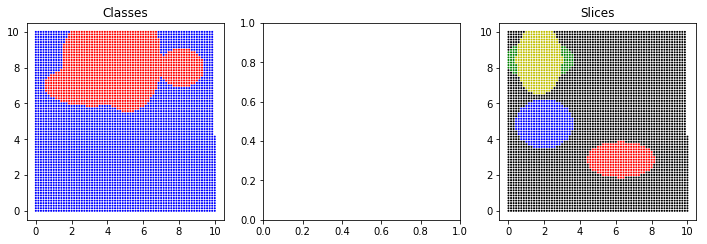

In [48]:
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model
from collections import defaultdict


model_configs = {
    "DP": dp_config,
    "UPx2": up_config,
    "UNI": uni_config,
    "MoE": moe_config,
    "SM": sm_config,
}

NUM_TRIALS = 1
k = 2
m = 3
n = 5000
num_slices = 3

history = defaultdict(list)
for trial in range(NUM_TRIALS):

    L, X, Y, Z, targeting_lfs_idx = generate_dataset(k, m, n, return_targeting_lfs=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)

    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)
        
        if model_name == "UNI":
            L_weights = list(np.ones(m))
            model = train_model(model_config, Ls, Xs, Ys, Zs, L_weights)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        if model_name.startswith('UP'):
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, targeting_lfs_idx)
        elif model_name == 'MoE':
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        else:
            model = train_model(model_config, Ls, Xs, Ys, Zs)

        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader)        
        
        # Save results
        history[model_name].append(results)

In [49]:
import pandas as pd

In [50]:
REPORTING_SLICES = ['all', 'slice_0', 'slice_1', 'slice_2', 'slice_3', 'slice_4']
METRIC_NAMAE = 'accuracy'

model_scores_by_slice = defaultdict(dict)
for model_name, scores in history.items():
    for slice_name in REPORTING_SLICES:
        collected_slice_scores = [s[slice_name][METRIC_NAMAE] for s in scores]
        mean_slice_score = sum(collected_slice_scores) / len(collected_slice_scores)
        model_scores_by_slice[model_name][slice_name] = mean_slice_score

pd.DataFrame.from_dict(model_scores_by_slice)

,DP,UPx2,UNI,MoE,SM
all,0.894000,0.880000,0.804000,0.758000,0.912000
slice_0,0.881481,0.864198,0.797531,0.760494,0.911111
slice_1,1.000000,1.000000,1.000000,1.000000,1.000000
slice_2,0.925000,0.925000,0.925000,0.925000,0.975000
slice_3,1.000000,1.000000,1.000000,0.428571,1.000000
slice_4,0.904762,0.904762,0.380952,0.190476,0.714286
